<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/20733/logos/header.png?t=2020-05-14-08-44-45">

# Utils

## Import Libraries

In [ ]:
# %%capture
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import load_img
from keras.preprocessing import image
!pip install -U --no-cache-dir gdown --pre
!gdown --id 1DS_5kLbzYYzMWtp1WP3x_hxtRBhroJID

# This chunk works.
!pip uninstall --yes gdown # After running this line, restart Colab runtime.

!pip install gdown -U --no-cache-dir

# import gdown

url = 'https://drive.google.com/file/d/1vdwK5hBxv28bqQNkTceBUv3Fx2VC9ds6/view?usp=sharing'

gdown.download_folder(url)

!gdown --id 1vdwK5hBxv28bqQNkTceBUv3Fx2VC9ds6
!unzip /content/batel_adi_weights01

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1DS_5kLbzYYzMWtp1WP3x_hxtRBhroJID
To: /content/labels_dic.csv
100% 6.14k/6.14k [00:00<00:00, 11.8MB/s]
Found existing installation: gdown 4.6.4
Uninstalling gdown-4.6.4:
  Successfully uninstalled gdown-4.6.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Retrieving folder list
Failed to retrieve folder contents:

 	Cannot retrieve the folder information from the link. You may need to
	change the permission to 'Anyone with the link'. 



/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1vdwK5hBxv28bqQNkTceBUv3Fx2VC9ds6
To: /content/batel_adi_weights01.zip
100% 1.92G/1.92G [00:41<00:00, 46.6MB/s]
Archive:  /content/batel_adi_weights01.zip
  inflating: batel_adi_weights/cnn4.h5  
  inflating: batel_adi_weights/cnn2.h5  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset
Cars196 - 196 different classes of vehicles

### Download Data

In [ ]:
%%capture
cars196 = tfds.load('Cars196', as_supervised=True, shuffle_files=True)

# New Section

Dictionary of the labels - maps between the label (int) number and the vehicle model (str)

In [ ]:
label_dic = pd.read_csv('/content/labels_dic.csv', header=None, dtype={0: str}).set_index(0).squeeze().to_dict()

### Function - Plot Single Example
This function receives an image and a label and it will display it on a plot

In [ ]:
def plot_single_example(image, label, label_dic=label_dic):
  car_model_by_label = label_dic[str(label)]
  plt.title(f'Image Label: {car_model_by_label} ({label})')
  plt.imshow(image)


# Data Preprocessing

### Split Dataset
Train set contains 8041 examples<br>
Test set contains 8144 examples<br>
**It is allowed to change the ratio between the data sets.**


In [ ]:
cars_train = cars196['train']
cars_test = cars196['test']
cars = cars_train.concatenate(cars_test)
TRAIN_SIZE = int(0.9 * len(cars))
TEST_SIZE = int(len(cars) - TRAIN_SIZE)
cars_train = cars.take(TRAIN_SIZE)
cars_test = cars.skip(TRAIN_SIZE)
VALIDATION_SIZE = int(0.2 * len(cars_train))
cars_train = cars_train.repeat(2)
cars_val = cars_train.take(VALIDATION_SIZE)
cars_train = cars_train.skip(VALIDATION_SIZE)
print(f'train size: {TRAIN_SIZE}, validation size: {VALIDATION_SIZE}, test size: {TEST_SIZE}')

train size: 14566, validation size: 2913, test size: 1619


### Example
Random example from the data set

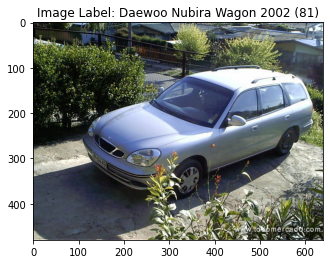

In [ ]:
image, label = cars_train.as_numpy_iterator().next()
plot_single_example(image, label)

In [ ]:
def preprocess(image, label):
  image=tf.image.resize(image,[128,128])
  image= tf.cast(image, tf.float32)/255.0
  return image, label

In [ ]:
def aug(image, label):
  image = tf.image.random_crop(image, size=[128, 128,3])
  image=tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, 0.1)
  image = tf.image.random_hue(image, 0.25)
  image = tf.image.random_saturation(image, 0, 2)
  return image, label

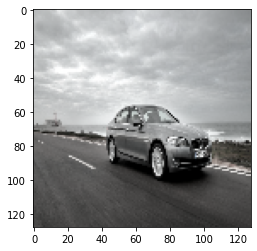

In [ ]:
for image,label in iter(cars_train):
  image,label=preprocess(image,label)
  image,label=aug(image,label)
  image = image/np.amax(image)
  image = np.clip(image, 0, 1)
  plt.imshow(image)
  break

In [ ]:
cars_train = cars_train.map(preprocess).map(aug).shuffle(800).batch(64).prefetch(tf.data.experimental.AUTOTUNE)
cars_val = cars_val.map(preprocess).shuffle(800).batch(64).prefetch(tf.data.experimental.AUTOTUNE)
cars_test = cars_test.map(preprocess).shuffle(800).batch(64).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay,confusion_matrix

def eval(model,cars_t):
  # Use the Keras model's predict method to make predictions on the test data
  predictions = model.predict(cars_t)
  y_true = np.concatenate([y.numpy() for x, y in cars_t], axis=0)
  # Evaluate the predictions using the test labels
  test_loss, test_accuracy = model.evaluate(cars_t)
  y_pred = [tf.argmax(pred).numpy() for pred in predictions]
  # Compute the confusion matrix using the predicted and true labels
  cm = confusion_matrix(y_true, y_pred)
  ConfusionMatrixDisplay.from_predictions(y_true,y_pred)
  print(classification_report(y_true,y_pred, labels=range(0,195)))
  plt.show()
  print('Test loss:', test_loss)
  print('Test accuracy:', test_accuracy)


def graphFunc(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

**First Configuration - End to End CNN**

base model

In [ ]:
cnn1 = tf.keras.models.Sequential()
cnn1.add(tf.keras.layers.Conv2D(32,kernel_size=(3,3),input_shape=(128,128,3),activation='relu'))
cnn1.add(tf.keras.layers.BatchNormalization())
cnn1.add(tf.keras.layers.MaxPooling2D(pool_size =(2,2),strides=2))
cnn1.add(tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
cnn1.add(tf.keras.layers.BatchNormalization())
cnn1.add(tf.keras.layers.MaxPooling2D(pool_size =(2,2),strides=2))
cnn1.add(tf.keras.layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
cnn1.add(tf.keras.layers.BatchNormalization())
cnn1.add(tf.keras.layers.MaxPooling2D(pool_size =(2,2),strides=2))
cnn1.add(tf.keras.layers.Flatten())
cnn1.add(tf.keras.layers.Dense(1024,activation='relu'))
cnn1.add(tf.keras.layers.Dropout(0.2))
cnn1.add(tf.keras.layers.Dense(196,activation='softmax'))
#cnn.summary()
cnn1.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=3, restore_best_weights=True)
history = cnn1.fit(cars_train, epochs=10, validation_data=cars_val, callbacks=[callback])

Epoch 1/10
410/410 [==============================] - 143s 263ms/step - loss: 5.7510 - accuracy: 0.0071 - val_loss: 6.1930 - val_accuracy: 0.0048
Epoch 2/10
410/410 [==============================] - 116s 258ms/step - loss: 5.2800 - accuracy: 0.0094 - val_loss: 5.2513 - val_accuracy: 0.0096
Epoch 3/10
410/410 [==============================] - 116s 257ms/step - loss: 5.2491 - accuracy: 0.0110 - val_loss: 5.2537 - val_accuracy: 0.0117
Epoch 4/10
410/410 [==============================] - 114s 252ms/step - loss: 5.2148 - accuracy: 0.0122 - val_loss: 5.1870 - val_accuracy: 0.0144
Epoch 5/10
410/410 [==============================] - 117s 259ms/step - loss: 5.2021 - accuracy: 0.0136 - val_loss: 5.1682 - val_accuracy: 0.0148
Epoch 6/10
410/410 [==============================] - 115s 254ms/step - loss: 5.1680 - accuracy: 0.0142 - val_loss: 5.1640 - val_accuracy: 0.0172
Epoch 7/10
410/410 [==============================] - 115s 255ms/step - loss: 5.1540 - accuracy: 0.0154 - val_loss: 5.2424 -

In [ ]:
cnn1.save('/content/drive/MyDrive/batel_adi_weights/cnn1.h5')

Loss&Accuracy

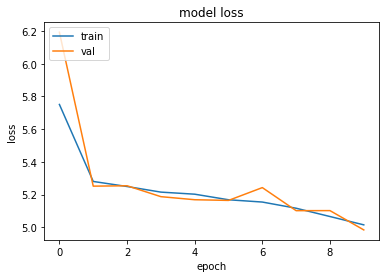

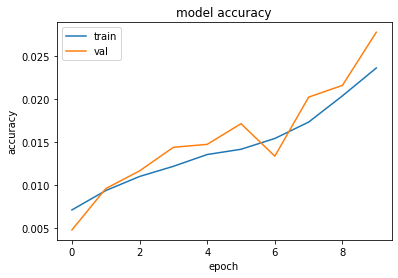

In [ ]:
graphFunc(history)

26/26 [==============================] - 41s 74ms/step - loss: 5.0493 - accuracy: 0.0173


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        13
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00         7
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         8
          16       0.00      0.00      0.00        10
          17       0.00    

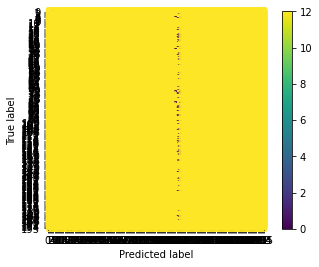

Test loss: 5.049312591552734
Test accuracy: 0.01729462668299675


In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/batel_adi_weights/cnn1.h5')
eval(model,cars_test)

First Experiment 

In [ ]:
cnn2 = tf.keras.models.Sequential()
cnn2.add(tf.keras.layers.Conv2D(32,kernel_size=(3,3),input_shape=(128,128,3),activation='relu'))
cnn2.add(tf.keras.layers.BatchNormalization())
cnn2.add(tf.keras.layers.MaxPooling2D(pool_size =(2,2),strides=2))
cnn2.add(tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
cnn2.add(tf.keras.layers.Dropout(0.2))
cnn2.add(tf.keras.layers.MaxPooling2D(pool_size =(2,2),strides=2))
cnn2.add(tf.keras.layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
cnn2.add(tf.keras.layers.BatchNormalization())
cnn2.add(tf.keras.layers.AveragePooling2D(pool_size =(2,2),strides=2))
cnn2.add(tf.keras.layers.Flatten())
cnn2.add(tf.keras.layers.Dense(4096,activation='relu'))
cnn2.add(tf.keras.layers.Dropout(0.2))
cnn2.add(tf.keras.layers.Dense(196,activation='softmax'))
#cnn.summary()
cnn2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=3, restore_best_weights=True)
history = cnn2.fit(cars_train, epochs=10, validation_data=cars_val, callbacks=[callback])

Epoch 1/10
410/410 [==============================] - 120s 262ms/step - loss: 5.0952 - accuracy: 0.0473 - val_loss: 6.0988 - val_accuracy: 0.0062
Epoch 2/10
410/410 [==============================] - 117s 260ms/step - loss: 3.3967 - accuracy: 0.2932 - val_loss: 4.4387 - val_accuracy: 0.1576
Epoch 3/10
410/410 [==============================] - 118s 262ms/step - loss: 1.8391 - accuracy: 0.6117 - val_loss: 2.9477 - val_accuracy: 0.4006
Epoch 4/10
410/410 [==============================] - 118s 263ms/step - loss: 0.9510 - accuracy: 0.7955 - val_loss: 2.1781 - val_accuracy: 0.5544
Epoch 5/10
410/410 [==============================] - 116s 259ms/step - loss: 0.5769 - accuracy: 0.8747 - val_loss: 1.2157 - val_accuracy: 0.7418
Epoch 6/10
410/410 [==============================] - 118s 261ms/step - loss: 0.3775 - accuracy: 0.9173 - val_loss: 1.0866 - val_accuracy: 0.7676
Epoch 7/10
410/410 [==============================] - 117s 262ms/step - loss: 0.3252 - accuracy: 0.9269 - val_loss: 0.9463 -

In [ ]:
cnn2.save('/content/drive/MyDrive/batel_adi_weights/cnn2.h5')

Loss&Accuracy

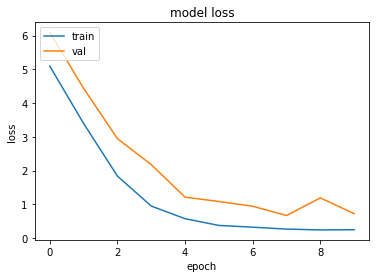

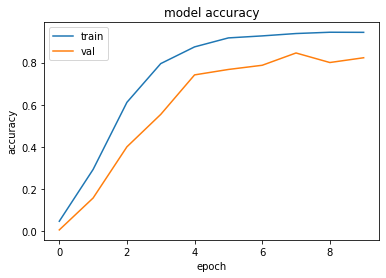

In [ ]:
graphFunc(history)

26/26 [==============================] - 41s 78ms/step - loss: 7.7807 - accuracy: 0.0945


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        13
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00         7
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         8
          16       0.00      0.00      0.00        10
          17       0.00    

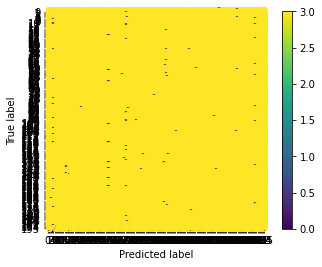

Test loss: 7.7806925773620605
Test accuracy: 0.0945027768611908


In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/batel_adi_weights/cnn2.h5')
eval(model,cars_test)

Second Experiment

In [ ]:
op = tf.keras.optimizers.legacy.SGD(
    learning_rate=0.01,
    decay=1e-5,
    momentum=0.9,
)

cnn4 = tf.keras.models.Sequential()
cnn4.add(tf.keras.layers.Conv2D(32,kernel_size=(3,3),input_shape=(128,128,3),activation='relu', kernel_initializer='glorot_uniform'))
cnn4.add(tf.keras.layers.BatchNormalization())
cnn4.add(tf.keras.layers.MaxPooling2D(pool_size =(2,2),strides=2))
cnn4.add(tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu', kernel_initializer='glorot_uniform'))
cnn4.add(tf.keras.layers.Dropout(0.2))
cnn4.add(tf.keras.layers.MaxPooling2D(pool_size =(2,2),strides=2))
cnn4.add(tf.keras.layers.Conv2D(128,kernel_size=(3,3),activation='relu', kernel_initializer='glorot_uniform'))
cnn4.add(tf.keras.layers.BatchNormalization())
cnn4.add(tf.keras.layers.AveragePooling2D(pool_size =(2,2),strides=2))
cnn4.add(tf.keras.layers.Flatten())
cnn4.add(tf.keras.layers.Dense(4096,activation='relu', kernel_initializer='glorot_uniform'))
cnn4.add(tf.keras.layers.Dropout(0.2))
cnn4.add(tf.keras.layers.Dense(196,activation='softmax'))
#cnn.summary()
cnn4.compile(optimizer = op, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=3, restore_best_weights=True)
history = cnn4.fit(cars_train, epochs=10, validation_data=cars_val, callbacks=[callback])

Epoch 1/10
410/410 [==============================] - 119s 262ms/step - loss: 4.9666 - accuracy: 0.0524 - val_loss: 4.9688 - val_accuracy: 0.0422
Epoch 2/10
410/410 [==============================] - 117s 262ms/step - loss: 3.4025 - accuracy: 0.2921 - val_loss: 3.7429 - val_accuracy: 0.2286
Epoch 3/10
410/410 [==============================] - 119s 264ms/step - loss: 1.7103 - accuracy: 0.6393 - val_loss: 2.4456 - val_accuracy: 0.4789
Epoch 4/10
410/410 [==============================] - 117s 262ms/step - loss: 0.7434 - accuracy: 0.8448 - val_loss: 1.9937 - val_accuracy: 0.5808
Epoch 5/10
410/410 [==============================] - 118s 261ms/step - loss: 0.3445 - accuracy: 0.9278 - val_loss: 1.2909 - val_accuracy: 0.7130
Epoch 6/10
410/410 [==============================] - 117s 261ms/step - loss: 0.1895 - accuracy: 0.9648 - val_loss: 0.6115 - val_accuracy: 0.8682
Epoch 7/10
410/410 [==============================] - 118s 262ms/step - loss: 0.1235 - accuracy: 0.9797 - val_loss: 0.3370 -

In [ ]:
cnn4.save('/content/drive/MyDrive/batel_adi_weights/cnn4.h5')

Loss&Accuracy

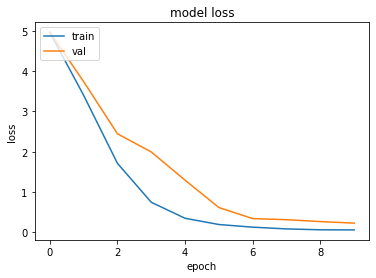

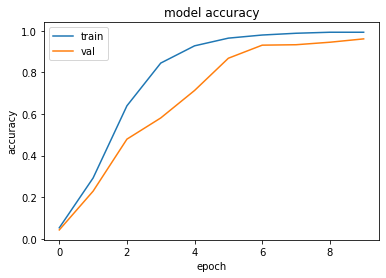

In [ ]:
graphFunc(history)

26/26 [==============================] - 41s 76ms/step - loss: 6.2065 - accuracy: 0.1279


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        13
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00         7
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         8
          16       0.00      0.00      0.00        10
          17       0.00    

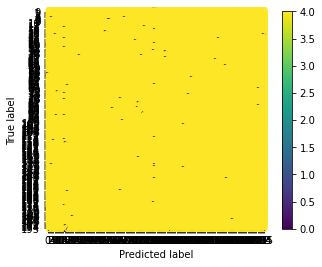

Test loss: 6.2064666748046875
Test accuracy: 0.12785670161247253


In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/batel_adi_weights/cnn4.h5')
eval(model,cars_test)

**Single Prediction**

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/batel_adi_weights/cnn4.h5')

In [ ]:
def get_single_prediction(image):
  plt.imshow(image[0])
  result = model.predict(image);
  maxIndex = np.argmax(result)
  label = label_dic.get(str(maxIndex))
  print(f'label {maxIndex}: {label}')
  return maxIndex, label

(128, 128, 3)
real label 121: GMC Canyon Extended Cab 2012
1/1 [==============================] - 0s 428ms/step
label 112: Ford F-150 Regular Cab 2012


(112, 'Ford F-150 Regular Cab 2012')

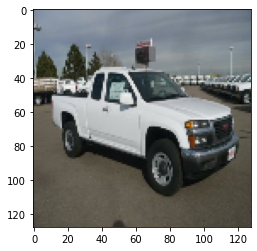

In [ ]:
batch = cars_test.as_numpy_iterator().next()
image, label = batch[0][0], batch[1][0]
print(image.shape)
test_image_as_batch = np.expand_dims(image, axis = 0)
labelstring = label_dic.get(str(label))
print(f'real label {label}: {labelstring}')
get_single_prediction(test_image_as_batch)

#Test on best model uploading an image

In [ ]:
from google.colab import files
from IPython.display import Image

In [ ]:
uploaded = files.upload()

Saving download.jpeg to download (1).jpeg


In [ ]:
import numpy as np
from keras.preprocessing import image
#add the path in the load image 
test_image = tf.keras.utils.load_img('/content/download.jpeg', target_size = (128, 128,3))
image=tf.image.resize(test_image,[128,128])
image= tf.cast(test_image, tf.float32)/255.0
model = keras.models.load_model('/content/batel_adi_weights/cnn4.h5')
test_image_as_batch = np.expand_dims(image, axis = 0)
result = model.predict(test_image_as_batch)
class_id = np.argmax(result)

1/1 [==============================] - 0s 253ms/step


Audi TT RS Coupe 2012
24


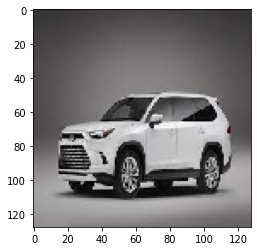

In [ ]:
label_dic = pd.read_csv('/content/labels_dic.csv', header=None, dtype={0: str}).set_index(0).squeeze().to_dict()
print(label_dic[str(class_id)])
print(class_id)
plt.imshow(image)

**KNN**

In [ ]:
cars_test = cars196['test']
fc_model = keras.Model(inputs=model.input, outputs=model.get_layer("flatten_2").output)
cars_t=cars_test.map(preprocess).shuffle(800).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
batch = cars_t.as_numpy_iterator().next()
images=batch[0]
labels=batch[1]

In [ ]:

# Assigns predicted label id's for the image_batch to variables
vectors = fc_model.predict(cars_t) 


252/252 [==============================] - 23s 84ms/step


In [ ]:
#checking we got a vector for every image
print(len(cars_test))
print(vectors.shape)

8041
(8041, 25088)


In [ ]:
from sklearn.neighbors import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(vectors)

NearestNeighbors(metric='euclidean')

In [ ]:
def get_similar(image, n_neighbors=5):
    # print(test_image_as_batch.shape)
    # test_image_as_batch = np.expand_dims(image, axis = 0)
    print("original image shape:")
    print(image.shape)
    image = image.reshape(1,128,128,3)
    vect = fc_model.predict(image) 
    print("image vectors shape:")
    print(vect.shape)
    #print(image.shape)
    #assert image.ndim==3,"image must be [batch,height,width,3]"
    (distances),(idx) = nei_clf.kneighbors(vect,n_neighbors=n_neighbors)
    print("distances in get_similar:")
    print(distances)
    print("idx in get_similar:")
    print(idx)
    return distances, idx

In [ ]:
def show_similar(image,label,neighbors):
    distances,idx = get_similar(image,n_neighbors=neighbors)

    plt.figure(figsize=[15,10])
    plt.subplot(1,4,1)
    plt.imshow(image)
    plt.title("Original image")
    print("original image class:")
    print(label)
    label = label_dic.get(str(label))
    print(f"Original image label:")
    print(label)
    
    data_enu = cars_t.unbatch().enumerate()
    for i in range(3):
      # print(type(list(data_enu.as_numpy_iterator())[0]))
      nei = data_enu.filter(lambda x,y:x==idx[0][i])
      # print(nei.as_numpy_iterator().next())
      nei_img = nei.as_numpy_iterator().next()[1][0]
      nei_lbl = nei.as_numpy_iterator().next()[1][1]
      print(f"neighbor {i} idx:")
      print(nei.as_numpy_iterator().next()[0])
      print(f"neighbor {i} class:")
      print(nei_lbl)
      # nei_pred = t128_model.predict(nei_img)
      # result_id = np.argmax(nei_pred)
      # print(nei_pred.shape)
      label = label_dic.get(str(nei_lbl))
      print(f"neighbor {i} label:")
      print(label)
      plt.subplot(1,4,i+2)
      plt.imshow(nei_img)
      plt.title(f"Dist={distances[0][i]}")
    plt.show()

original image shape:
(128, 128, 3)
1/1 [==============================] - 0s 95ms/step
image vectors shape:
(1, 25088)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


distances in get_similar:
[[1.18708512e-04 1.36134462e+02 1.38282913e+02]]
idx in get_similar:
[[ 973 1718 4372]]
original image class:
37
Original image label:
BMW Z4 Convertible 2012
neighbor 0 idx:
973
neighbor 0 class:
182
neighbor 0 label:
Suzuki SX4 Hatchback 2012
neighbor 1 idx:
1718
neighbor 1 class:
93
neighbor 1 label:
Dodge Durango SUV 2012
neighbor 2 idx:
4372
neighbor 2 class:
70
neighbor 2 label:
Chevrolet Express Van 2007


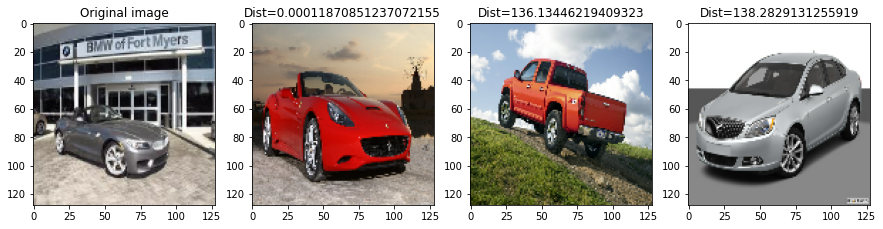

In [ ]:
image, label = cars_t.unbatch().as_numpy_iterator().next()
show_similar(image, label, neighbors=3)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
vectors_to_class = fc_model.predict(images) 
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(vectors_to_class, labels)
image= np.reshape(image, (1,128,128,3))
print(image.shape)
image_vec = fc_model.predict(image) 
print(neigh.predict(image_vec))
print(f'real label: {label}')
print(neigh.predict_proba(image_vec))
score = neigh.score(vectors_to_class,labels)
print(f'the accuracy score is: {score}')

1/1 [==============================] - 0s 31ms/step
(1, 128, 128, 3)
1/1 [==============================] - 0s 18ms/step
[0]
real label: 37
[[0.33333333 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.33333333 0.         0.         0.         0.
  0.         0.         0.         0.33333333 0.         0.
  0.         0.         0.         0.         0.         0.        ]]
the accuracy score is: 0.3125
